In [69]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed


In [70]:
# Create the parser
parser = argparse.ArgumentParser(description="Process some parameters for clustering.")
# Add required arguments
parser.add_argument("Ncores", type=int, help="Number of CPU's")
parser.add_argument("file_path", type=str, help="Path to the file")
parser.add_argument("parent_directory", type=str, help="Parent directory")
parser.add_argument("results_directory", type=str, help="Results directory")
parser.add_argument("tmin", type=int, help="Minimum time")
parser.add_argument("tmax", type=int, help="Maximum time")
parser.add_argument("lat_resolution", type=float, help="Lat resolution for the IC grid in degrees")
parser.add_argument("lon_resolution", type=float, help="Lon resolution for the IC grid in degrees")
parser.add_argument("dt", type=float, help="Time step size for Runge Kutta")
parser.add_argument("DT", type=float, help="Time step size for Fmap")
parser.add_argument("geodesic", type=lambda x: x.lower() == 'true', help="Geodesic boolean for trajectory distance")
# Add optional argument with a default value
parser.add_argument("--freq", type=int, default=10, help="Frequency (default: 10)")
parser.add_argument("--K", type=int, default=1000, help="K similarity diagonal (default: 1000)")
# Parse the arguments
args = parser.parse_args()

Ncores = args.Ncores
file_path = args.file_path
parent_directory = args.parent_directory
results_directory = args.results_directory
tmin = args.tmin
tmax = args.tmax
lat_resolution = args.lat_resolution
lon_resolution = args.lon_resolution
dt = args.dt
DT = args.DT
geodesic = args.geodesic
freq = args.freq
K = args.K

"""
K=1000
Ncores = 10
file_path = "/home/llu/Data/OPA-neXtSIM_CREG025_ILBOXE140_2000_ice_90Rx.nc"
parent_directory = "/home/llu/Programs/HPC_Spectral_Clustering/"
tmin = 0
tmax = 360
lat_resolution = 0.25
lon_resolution = 0.25
dt = 1
DT = 10
freq = 1
timemod = int(DT/dt) #10
geodesic=True
"""


Fmap_params = (
    f"tmin{tmin}_"
    f"tmax{tmax}_"
    f"latlonres{lat_resolution}x{lon_resolution}_"
    f"dt{dt}_"
    f"DT{DT}"
)

W_params = (
    f"geodesic_{geodesic}"
)


usage: ipykernel_launcher.py [-h] [--freq FREQ] [--K K]
                             [--n_clusters N_CLUSTERS] [--e E]
                             Ncores file_path parent_directory
                             results_directory tmin tmax lat_resolution
                             lon_resolution dt DT geodesic
ipykernel_launcher.py: error: argument --freq: invalid int value: '/home/llu/.local/share/jupyter/runtime/kernel-v3713d7307a19f20aa04b19c012023d066a639c466.json'


SystemExit: 2

/home/llu/venvs/Spectral_Clustering_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [60]:
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")

from ipynb.fs.defs.similarity_matrix import similarity_matrix
from ipynb.fs.defs.trajectory_distance import integral_vec

In [61]:
#Read input data
Fmap_path = file_path+'/Fmap_matrix.npy'
time_path = file_path+'/advection_time.npy'
# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)

#Fmap=Fmap[:,:,::100]


In [63]:
print("Preparing the parallel loop to compute the Similarity matrix") 
n = Fmap.shape[2]
print(f"{n} trajectories are being processed. Each trajectory has {Fmap.shape[0]} time steps.")

indices = np.tril_indices(n,0,n)

I=indices[0]
J=indices[1]

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

I_batch = list(split(I, Ncores)) # list (Nx*Ny)
J_batch = list(split(J, Ncores)) # list (Nx*Ny)
print("Dimensions of W triangular")
print(n*n/2+n/2)

print("Length of the array with w values")
print(I_batch[0].shape)


Preparing the parallel loop to compute the Similarity matrix
500 trajectories are being processed. Each trajectory has 9 time steps.
Dimensions of W triangular
125250.0
Length of the array with w values
(12525,)


In [65]:
print("Computing the similarity matrix with the parallel loop")
results = Parallel(n_jobs=Ncores, verbose = 10)(delayed(similarity_matrix)(Fmap, I_batch[i], J_batch[i],K,time_adv_mod,geodesic=geodesic) for i in range(len(I_batch)))

W_vec = results[0]

for res in results[1:]:
    W_vec = np.append(W_vec, res)

del(results)


Computing the similarity matrix with the parallel loop
0
0
0
0
0
0
0
0
0
0


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


10000
10000
10000
10000
10000


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    6.2s remaining:   14.4s


10000
10000


[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    6.8s remaining:    6.8s


10000
10000
10000


[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    7.6s remaining:    3.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    8.1s finished


In [66]:
np.save(results_directory+'/W_matrix_'+W_params+'.npy', W_vec)

In [67]:
# Create an empty matrix of zeros with shape (n, n)
W = np.zeros((n, n))
W[indices] = W_vec
# Fill the upper triangular part 
W = W + W.T - np.diag(np.diag(W))
np.fill_diagonal(W, 0)

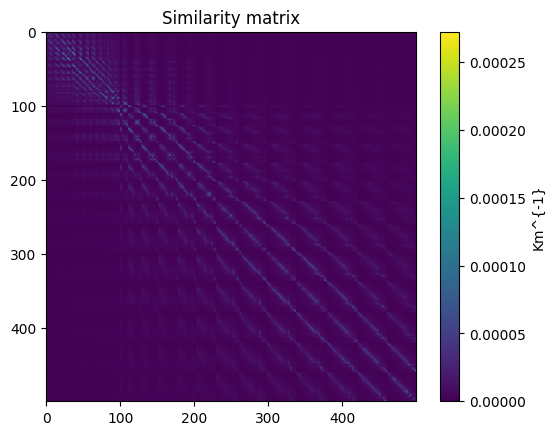

In [68]:
imshow(W)
cb=plt.colorbar()
if geodesic==True:
    cb.set_label("m^{-1}")
else:
    cb.set_label("deg^{-1}")
plt.title("Similarity matrix")
plt.savefig(results_directory+'/W_matrix_'+W_params+'.png')
